In [0]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/'My Drive'/'Colab Notebooks'
!mkdir ./data
!cp -r /content/drive/'My Drive'/'Colab Notebooks'/kickstarter-projects/  ./data/
!cd data
!ls


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
dl4us-master	     im_gen.ipynb	     logging.conf      Untitled0.ipynb
dogsandcats	     kickstarter.ipynb	     MountDrive.ipynb
dogs_and_cats.ipynb  kickstarter-projects    RGB_Div.ipynb
http_requests.ipynb  kickstarter_tada.ipynb  seminor.ipynb
data  drive  sample_data


In [0]:
!ls ./data/kickstarter-projects


ks-projects-201612.csv	ks-projects-201801.csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pylab import rcParams

### 初期設定
# グラフ描画サイズ設定
rcParams['figure.figsize'] = 10, 10
# 標準化処理オブジェクト
stdsc = StandardScaler()


In [0]:
# データの読込み
df_ks = pd.read_csv("./data/kickstarter-projects/ks-projects-201801.csv")
# データ参照
df_ks.head()


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


IDとnameは○○変数のため処理対象外とし削除する

In [0]:
# 処理対象外列を削除
df_ks = df_ks.drop('ID', axis=1).drop('name', axis=1)
# データ参照
df_ks.head()


,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [0]:
# データの要約情報を表示
df_ks.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


説明変数として期間データを作成

In [0]:
# 日付計算
df_ks['delta'] = (pd.to_datetime(df_ks["deadline"]).dt.date - pd.to_datetime(df_ks["launched"]).dt.date).astype('timedelta64[D]')
# 処理済み列を削除
df_ks = df_ks.drop('launched', axis=1).drop('deadline', axis=1)


In [0]:
# データ参照
df_ks.head()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,delta
0,Poetry,Publishing,GBP,1000.0,0.0,failed,0,GB,0.0,0.0,1533.95,59.0
1,Narrative Film,Film & Video,USD,30000.0,2421.0,failed,15,US,100.0,2421.0,30000.00,60.0
2,Narrative Film,Film & Video,USD,45000.0,220.0,failed,3,US,220.0,220.0,45000.00,45.0
3,Music,Music,USD,5000.0,1.0,failed,1,US,1.0,1.0,5000.00,30.0
4,Film & Video,Film & Video,USD,19500.0,1283.0,canceled,14,US,1283.0,1283.0,19500.00,56.0


各データの平均値と最大値に開きがあるため外れ値処理を実施

In [0]:
# 外れ値対応
def outlier_iqr(df):

    for i in range(len(df.columns)):

        if df.dtypes[i] != 'object':
            # 列を抽出する
            col = df.iloc[:,i]

            # 四分位数
            q1 = col.describe()['25%']
            q3 = col.describe()['75%']
            iqr = q3 - q1 #四分位範囲

            # 外れ値の基準点
            outlier_min = q1 - (iqr) * 1.5
            outlier_max = q3 + (iqr) * 1.5

            # 範囲から外れている値を除く
            col[col < outlier_min] = None
            col[col > outlier_max] = None

    return df

# 外れ値対応（データ削除）
df_ks = outlier_iqr(df_ks)

# 外れ値対応でNanに置換されたデータを行単位で削除
df_ks = df_ks.dropna(how='any')

# 要約情報を表示
df_ks.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,delta
count,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000
mean,6704.388752,1252.988999,21.201530,1054.271207,1267.709923,6759.486748,31.165681
std,7598.276541,1818.721599,28.393545,1645.995760,1828.435060,7648.763671,5.432621
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,20.000000
25%,1500.000000,21.000000,1.000000,10.000000,22.000000,1500.000000,30.000000
50%,4000.000000,335.000000,8.000000,215.000000,341.000000,4000.000000,30.000000
75%,10000.000000,1821.000000,31.000000,1399.000000,1858.000000,9500.000000,31.000000
max,37000.000000,10140.000000,137.000000,7559.000000,10078.000000,35750.000000,47.000000


各種数値データの単位が揃っていないため標準化を実施する対象列は以下の通り
*   goal
*   pledged
*   backers
*   usd pledged
*   usd_pledged_real
*   usd_goal_real


In [0]:
def standardizationColumn(df_worker, columnName):
    # 標準化
    data = stdsc.fit_transform(df_worker[[columnName]].values)
    # 標準化済みデータを新規列としてデータフレームに追加
    df_worker['{0}_std'.format(columnName)] = data
    # 処理済み列を削除
    df_worker = df_worker.drop(columnName, axis=1, inplace=True)

# IDは対象外

# goal
standardizationColumn(df_ks, 'goal')
# pledged
standardizationColumn(df_ks, 'pledged')
# backers
standardizationColumn(df_ks, 'backers')
# usd pledged
standardizationColumn(df_ks, 'usd pledged')
# usd_pledged_real
standardizationColumn(df_ks, 'usd_pledged_real')
# usd_goal_real
standardizationColumn(df_ks, 'usd_goal_real')
# delta(日付情報)
standardizationColumn(df_ks, 'delta')

# 要約情報を表示
df_ks.describe()

,goal_std,pledged_std,backers_std,usd pledged_std,usd_pledged_real_std,usd_goal_real_std,delta_std
count,2.134220e+05,2.134220e+05,2.134220e+05,2.134220e+05,2.134220e+05,2.134220e+05,2.134220e+05
mean,3.183712e-16,1.158797e-15,3.338947e-16,5.901392e-17,-9.883036e-17,1.164771e-16,1.029410e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-8.823573e-01,-6.889410e-01,-7.467042e-01,-6.405081e-01,-6.933322e-01,-8.837366e-01,-2.055308e+00
25%,-6.849449e-01,-6.773944e-01,-7.114849e-01,-6.344328e-01,-6.813000e-01,-6.876273e-01,-2.145712e-01
50%,-3.559222e-01,-5.047453e-01,-4.649494e-01,-5.098878e-01,-5.068335e-01,-3.607764e-01,-2.145712e-01
75%,4.337324e-01,3.123141e-01,3.450958e-01,2.094353e-01,3.228397e-01,3.582958e-01,-3.049753e-02
max,3.987178e+00,4.886417e+00,4.078347e+00,3.951860e+00,4.818498e+00,3.790231e+00,2.914681e+00


In [0]:
# ステータスのダミーデータ作成
df_ks = pd.get_dummies(df_ks, columns=['state'])
# 成功、失敗以外の列を削除
# df_ks = df_ks.drop('state_suspended', axis=1).drop('state_undefined', axis=1).drop('state_live', axis=1).drop('state_failed', axis=1).drop('state_canceled', axis=1)
df_ks = df_ks.drop('state_suspended', axis=1).drop('state_live', axis=1).drop('state_failed', axis=1).drop('state_canceled', axis=1)


In [0]:
# データ参照
df_ks.head()

,category,main_category,currency,country,goal_std,pledged_std,backers_std,usd pledged_std,usd_pledged_real_std,usd_goal_real_std,delta_std,state_successful
3,Music,Music,USD,US,-0.224313,-0.688391,-0.711485,-0.639901,-0.692785,-0.230036,-0.214571,0
6,Food,Food,USD,US,-0.750749,-0.026386,-0.183195,0.091573,-0.034297,-0.752998,-2.055308,1
7,Drinks,Food,USD,US,2.407869,-0.439864,0.662070,-0.365294,-0.445579,2.384772,2.546533,0
10,Nonfiction,Publishing,CAD,CA,-0.553336,-0.688941,-0.746704,-0.640508,-0.693332,-0.569126,-0.214571,0
12,Crafts,Crafts,USD,US,-0.224313,-0.688941,-0.746704,-0.640508,-0.693332,-0.230036,-0.214571,0


外れ値処理後の数値データに関する相関を確認する

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


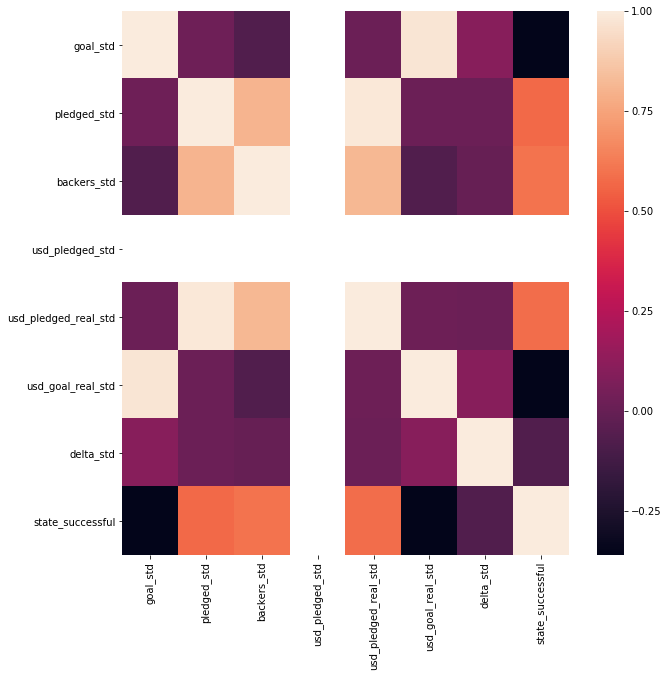

In [0]:
# 数値データ列の抽出
df_ks_worker = df_ks.loc[:, ['goal_std', 'pledged_std', 'backers_std', 'usd_pledged_std', 'usd_pledged_real_std', 'usd_goal_real_std', 'delta_std', 'state_successful']]
# 数値データのヒートマップを出力
sns.heatmap(df_ks_worker.corr())

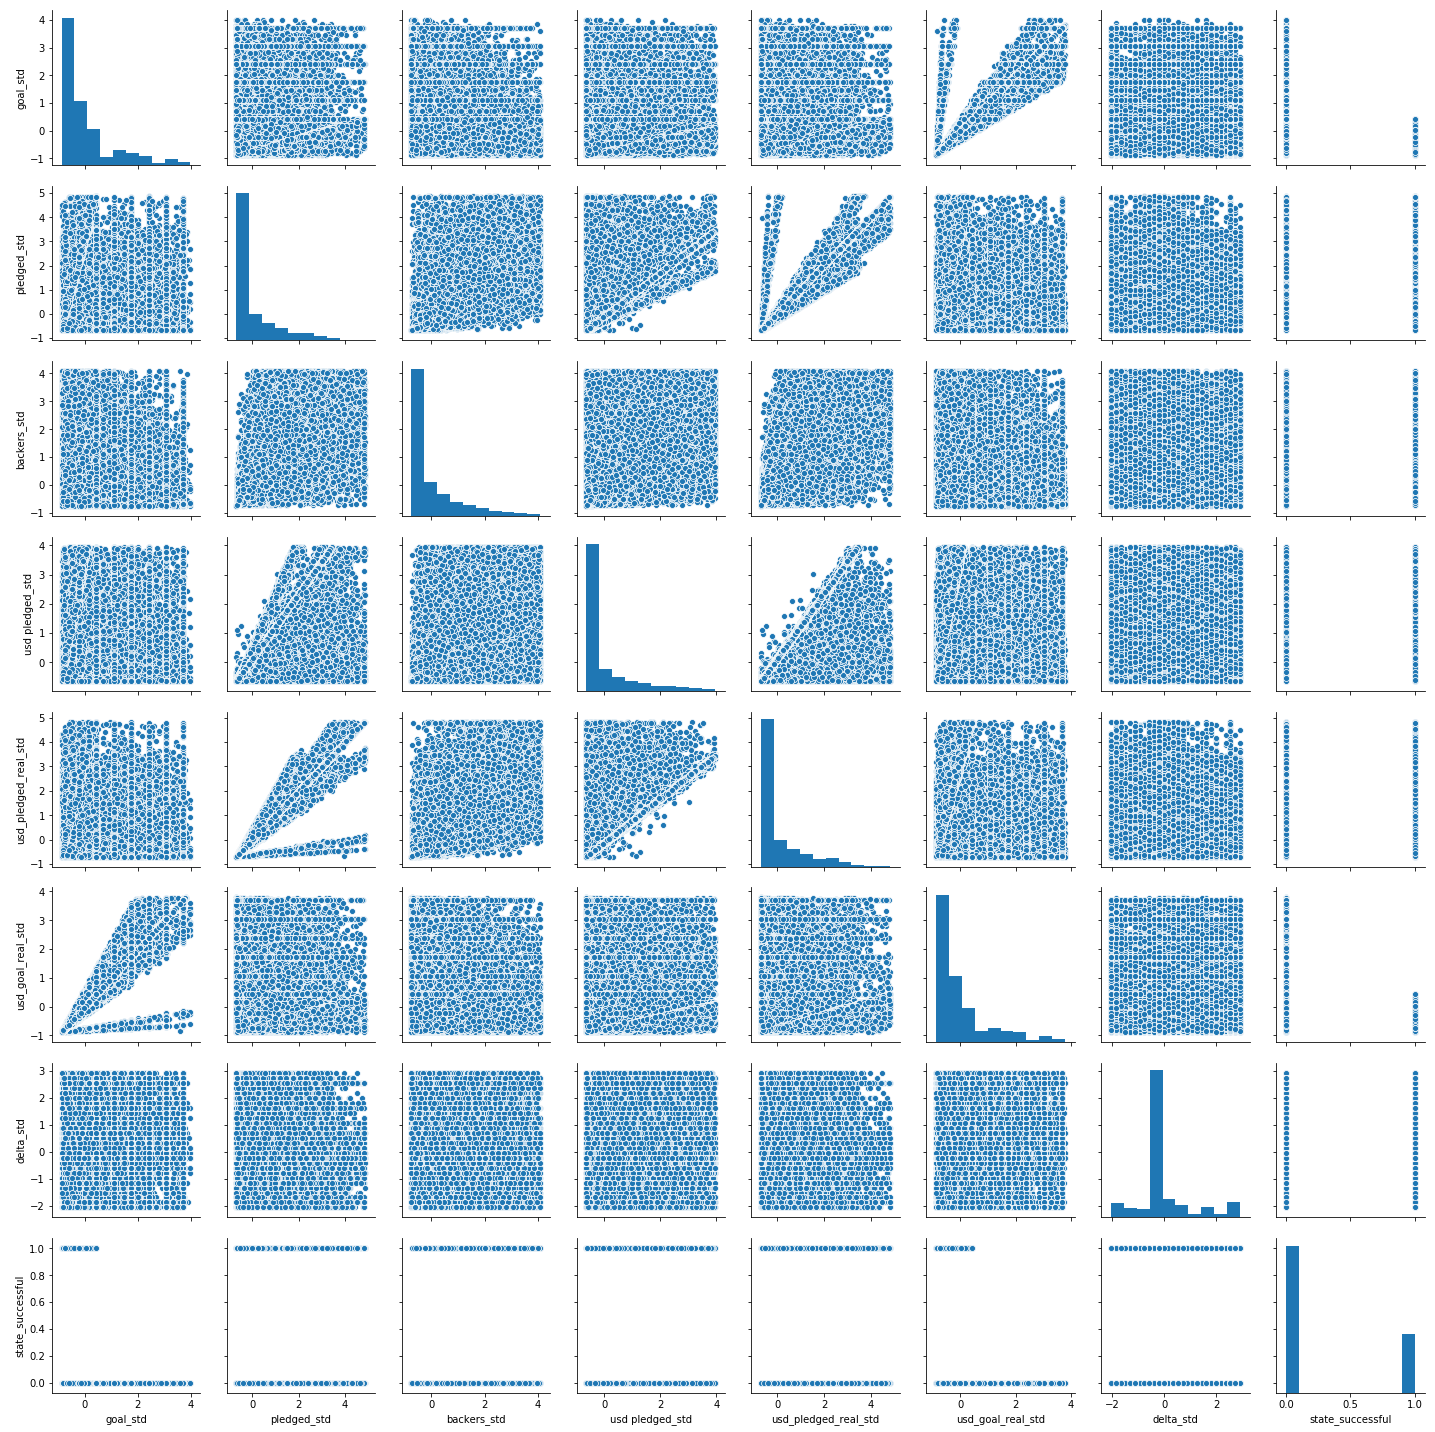

In [0]:
# 散布図行列を出力
sns.pairplot(df_ks)


データの編集処理を実施


*   kickstarter実施期間列を追加
*   文字列データに対してダミデータを作成
*   編集処理後の不要な列を削除



In [0]:
# kickstarter開始時の未確定データ列の削除
df_ks = df_ks.drop('backers_std', axis=1).drop('pledged_std', axis=1)
df_ks.head()

,category,main_category,currency,country,goal_std,usd pledged_std,usd_pledged_real_std,usd_goal_real_std,delta_std,state_successful
3,Music,Music,USD,US,-0.224313,-0.639901,-0.692785,-0.230036,-0.214571,0
6,Food,Food,USD,US,-0.750749,0.091573,-0.034297,-0.752998,-2.055308,1
7,Drinks,Food,USD,US,2.407869,-0.365294,-0.445579,2.384772,2.546533,0
10,Nonfiction,Publishing,CAD,CA,-0.553336,-0.640508,-0.693332,-0.569126,-0.214571,0
12,Crafts,Crafts,USD,US,-0.224313,-0.640508,-0.693332,-0.230036,-0.214571,0


In [0]:
# 国別成功データ件数
df_worker = df_ks.groupby(['country'])['state_successful'].sum()
df_worker.head()


country
AT      36.0
AU     869.0
BE      63.0
CA    1952.0
CH      56.0
Name: state_successful, dtype: float64

In [0]:
# カテゴリー別成功データ件数
df_ks.groupby(['category'])['state_successful'].sum()


category
3D Printing            31.0
Academic              108.0
Accessories           459.0
Action                 43.0
Animals                32.0
Animation             278.0
Anthologies           186.0
Apparel               513.0
Apps                  131.0
Architecture           68.0
Art                  1986.0
Art Books             564.0
Audio                  60.0
Bacon                  18.0
Blues                  67.0
Calendars              49.0
Camera Equipment       16.0
Candles                42.0
Ceramics               70.0
Children's Books     1319.0
Childrenswear          40.0
Chiptune               11.0
Civic Design           33.0
Classical Music       917.0
Comedy                455.0
Comic Books           956.0
Comics               1183.0
Community Gardens      39.0
Conceptual Art        209.0
Cookbooks              42.0
                      ...  
Shorts               3953.0
Small Batch           236.0
Software              119.0
Sound                  44.0
Space Explo

In [0]:
# カテゴリー別成功データ件数
df_ks.groupby(['main_category'])['state_successful'].sum()


main_category
Art              6834.0
Comics           2802.0
Crafts           1331.0
Dance            1476.0
Design           2614.0
Fashion          2311.0
Film & Video    10809.0
Food             2097.0
Games            3082.0
Journalism        475.0
Music           13371.0
Photography      1655.0
Publishing       6588.0
Technology       1366.0
Theater          4017.0
Name: state_successful, dtype: float64

In [0]:
# 実施日数別成功データ件数
df_ks.groupby(['delta_std'])['state_successful'].sum()

delta_std
-2.055308     2143.0
-1.871234     2457.0
-1.687160     1003.0
-1.503087      814.0
-1.319013      849.0
-1.134939     1826.0
-0.950866      877.0
-0.766792      835.0
-0.582718     1472.0
-0.398645     1439.0
-0.214571    30584.0
-0.030498     3002.0
 0.153576     1699.0
 0.337650     1213.0
 0.521723      801.0
 0.705797     1705.0
 0.889871      705.0
 1.073944      528.0
 1.258018      446.0
 1.442092      392.0
 1.626165     1606.0
 1.810239      423.0
 1.994312      400.0
 2.178386      287.0
 2.362460      298.0
 2.546533     2311.0
 2.730607      458.0
 2.914681      255.0
Name: state_successful, dtype: float64

In [0]:
# 通貨別成功データ件数
df_ks.groupby(['currency'])['state_successful'].sum()

currency
AUD      869.0
CAD     1952.0
CHF       56.0
DKK       56.0
EUR     1495.0
GBP     6102.0
HKD       12.0
JPY        0.0
MXN       20.0
NOK       15.0
NZD      191.0
SEK       65.0
SGD       54.0
USD    49941.0
Name: state_successful, dtype: float64

In [0]:
# 欠損値の確認
df_ks.isnull().sum()

category                0
main_category           0
currency                0
country                 0
goal_std                0
usd pledged_std         0
usd_pledged_real_std    0
usd_goal_real_std       0
delta_std               0
state_successful        0
dtype: int64

In [0]:
# 欠損値を削除
df_ks = df_ks.dropna(how='any')
# データ参照
df_ks.head()


,category,main_category,currency,country,goal_std,usd pledged_std,usd_pledged_real_std,usd_goal_real_std,delta_std,state_successful
3,Music,Music,USD,US,-0.224313,-0.639901,-0.692785,-0.230036,-0.214571,0
6,Food,Food,USD,US,-0.750749,0.091573,-0.034297,-0.752998,-2.055308,1
7,Drinks,Food,USD,US,2.407869,-0.365294,-0.445579,2.384772,2.546533,0
10,Nonfiction,Publishing,CAD,CA,-0.553336,-0.640508,-0.693332,-0.569126,-0.214571,0
12,Crafts,Crafts,USD,US,-0.224313,-0.640508,-0.693332,-0.230036,-0.214571,0


In [0]:
# category と main_caegory は同じ意味合いのため削除
df_ks = df_ks.drop('main_category', axis=1)

In [0]:
# ダミーデータ作成
df_ks = pd.get_dummies(df_ks, columns=['category'])
df_ks = pd.get_dummies(df_ks, columns=['currency'])
df_ks = pd.get_dummies(df_ks, columns=['country'])

# データ参照
df_ks.head()


,goal_std,usd pledged_std,usd_pledged_real_std,usd_goal_real_std,delta_std,state_successful,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,...,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
3,-0.224313,-0.639901,-0.692785,-0.230036,-0.214571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,-0.750749,0.091573,-0.034297,-0.752998,-2.055308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,2.407869,-0.365294,-0.445579,2.384772,2.546533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10,-0.553336,-0.640508,-0.693332,-0.569126,-0.214571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,-0.224313,-0.640508,-0.693332,-0.230036,-0.214571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
# 正則化


# データ参照
df_ks.head()


,goal_std,usd pledged_std,usd_pledged_real_std,usd_goal_real_std,delta_std,state_successful,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,...,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
3,-0.224313,-0.639901,-0.692785,-0.230036,-0.214571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,-0.750749,0.091573,-0.034297,-0.752998,-2.055308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,2.407869,-0.365294,-0.445579,2.384772,2.546533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10,-0.553336,-0.640508,-0.693332,-0.569126,-0.214571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,-0.224313,-0.640508,-0.693332,-0.230036,-0.214571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
# データ参照
df_ks.describe()


,goal_std,usd pledged_std,usd_pledged_real_std,usd_goal_real_std,delta_std,state_successful,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,...,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
count,2.134220e+05,2.134220e+05,2.134220e+05,2.134220e+05,2.134220e+05,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,...,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000,213422.000000
mean,3.183712e-16,5.901392e-17,-9.883036e-17,1.164771e-16,1.029410e-15,0.285013,0.001171,0.002680,0.009263,0.001720,0.000834,0.005988,0.001776,0.021886,0.015322,0.001495,0.024782,0.006925,0.001331,0.000647,0.000801,0.000951,0.000623,0.001626,0.000961,0.022341,0.001537,0.000084,0.000511,0.007178,0.006316,0.008523,0.013869,0.000829,0.003092,0.001546,0.012782,0.000815,0.016020,0.000604,...,0.000525,0.005768,0.002858,0.001279,0.020987,0.040511,0.001551,0.001438,0.043876,0.095276,0.000403,0.000005,0.001673,0.000867,0.003997,0.002052,0.001321,0.786044,0.001523,0.020987,0.001612,0.040511,0.001551,0.010627,0.001438,0.006110,0.007113,0.095276,0.000403,0.002169,0.007113,0.000005,0.000136,0.001673,0.007473,0.000867,0.003997,0.002052,0.001321,0.786044
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.451422,0.034206,0.051701,0.095800,0.041432,0.028868,0.077151,0.042103,0.146312,0.122829,0.038632,0.155460,0.082930,0.036455,0.025420,0.028295,0.030826,0.024956,0.040290,0.030978,0.147789,0.039173,0.009183,0.022594,0.084420,0.079223,0.091926,0.116948,0.028786,0.055524,0.039292,0.112334,0.028542,0.125552,0.024578,...,0.022902,0.075728,0.053386,0.035742,0.143340,0.197156,0.039351,0.037900,0.204819,0.293597,0.020070,0.002165,0.040865,0.029429,0.063094,0.045256,0.036326,0.410097,0.038993,0.143340,0.040115,0.197156,0.039351,0.102538,0.037900,0.077927,0.084036,0.293597,0.020070,0.046526,0.084036,0.002165,0.011656,0.040865,0.086126,0.029429,0.063094,0.045256,0.036326,0.410097
min,-8.823573e-01,-6.405081e-01,-6.933322e-01,-8.837366e-01,-2.055308e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [0]:
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数

# 目的変数データ
y = df_ks["state_successful"].values
# 説明変数データ
X = df_ks.drop('state_successful', axis=1).values

# 全データのうち、何%をテストデータにするか（今回は20%に設定）
test_size = 0.3
# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# Scikit-learnを用いてロジスティック回帰
# clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf = SGDClassifier(loss='log', penalty='elasticnet', max_iter=5, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)



# モデル評価



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# 重みを取得して表示(w0)
w0 = clf.intercept_[0]
print("w0:{0}".format(w0))

# 重みを取得して表示(w1-)
for i in range(len(clf.coef_[0])):
    print("w{0} = {1}".format(i, clf.coef_[0, i]))



w0:-17.16568767101114
w0 = -10.544036791812482
w1 = 0.9786744679514224
w2 = 7.5634872029857005
w3 = -15.037458324527018
w4 = -0.10730457919840714
w5 = 0.0
w6 = 0.0
w7 = -0.1433403250642671
w8 = 0.0
w9 = 0.0
w10 = 0.0
w11 = 0.0
w12 = -0.35940731540554843
w13 = -0.30187828458781396
w14 = 0.030259284236581287
w15 = 0.11399926501462851
w16 = 0.1321055795603402
w17 = 0.0
w18 = -0.40423282282905393
w19 = 0.0
w20 = 0.0
w21 = -0.020561627219872817
w22 = -0.13158229699147161
w23 = 0.0
w24 = 0.2661615975802709
w25 = 0.0
w26 = 0.0
w27 = 0.0
w28 = 0.4364178429142963
w29 = 0.07959238917638493
w30 = 0.3995173397216306
w31 = 0.22891663200525778
w32 = 0.0
w33 = 0.0
w34 = -0.11765217428915943
w35 = 0.5448940977072246
w36 = 0.0
w37 = -0.21668590509350188
w38 = 0.0
w39 = -0.19767119859139934
w40 = -0.049783404559875656
w41 = 0.4821121219473673
w42 = -0.3264456188102764
w43 = -0.25093993055543357
w44 = 0.15548337238503412
w45 = 0.31321369071177035
w46 = -0.362289786897207
w47 = 0.0
w48 = 0.0
w49 = -0.2112

In [0]:
# ラベルを予測
y_test_p = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(-log_loss(y, y_test_p)))

# 正答率を表示
print('正答率 = {}%'.format(100 * accuracy_score(y, y_test_p)))


対数尤度 = -0.498
正答率 = 98.55919258558163%


In [0]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train)
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)


####### RMSE : 予測と実際の差の二乗の平均の平方根 #######
# 学習データに対するMAEを計算（訓練誤差の評価）
rmse_test = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE_TEST = %s" % round(rmse_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE_TRAIN = %s" % round(rmse_train, 3) )

####### MAE : 予測と実際の差の絶対値の平均 #######

# 学習データに対するMAEを計算（訓練誤差の評価）
mae_test = mean_absolute_error(y_train, y_pred_train)
print("MAE_TEST = %s" % round(mae_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
mae_train = mean_absolute_error(y_test, y_pred_test)
print("MAE_TRAIN = %s" % round(mae_train, 3) )

####### MSE : 予測と実際の差の二乗の平均 #######
# 学習データに対するMAEを計算（訓練誤差の評価）
mse_test = mean_squared_error(y_train, y_pred_train)
print("MSE_TEST = %s" % round(mse_test, 3) )

# テストデータに対するMAEを計算（汎化誤差の評価）
mse_train = mean_squared_error(y_test, y_pred_test)
print("MSE_TRAIN = %s" % round(mse_train, 3) )


RMSE_TEST = 0.12
RMSE_TRAIN = 0.12
MAE_TEST = 2.418
MAE_TRAIN = 2.434
MSE_TEST = 0.014
MSE_TRAIN = 0.014


In [0]:
# おまけ

# # 日付計算

# import datetime
# from datetime import datetime as dt

# def str_to_datetime1(t):
#     return datetime.datetime.strptime(t[:10], '%Y-%m-%d')

# # def str_to_datetime2(t):
# #     return datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S')

# def delta(t):
#     t1, t2 = t
#     delta = t2 - t1
#     return (int)(delta.total_seconds() / (60 * 60 * 24))


# # 開始日時、終了日を日付型に変換
# df_ks['datetime_1'] = df_ks['launched'].apply(str_to_datetime1)
# df_ks['datetime_2'] = df_ks['deadline'].apply(str_to_datetime1) 

# # 開始日時、終了日の差を計算
# df_ks['delta'] = df_ks[['datetime_1', 'datetime_2']].apply(delta, axis=1)
# # print(df_ks['delta'])
